# Sparse Nonlinear Least Squares

We're interested in nonlinear least squares problems of the form

$$min_x \|f(x)\|_2^2,$$

but prefer $x$ to be sparse. I proposed to tackle this by a reparametrization trick. I'm interested to know if prox methods could do this better, especially if they're adapted to second order methods. To this end, I'm going to try SKGLM on a linear version of the above, with $f(x) = Ax$.

In [243]:
from typing import Dict, NamedTuple

import dataclasses as dc
import time

import numpy as np
import matplotlib.pylab as plt


class Run(NamedTuple):
    w: np.ndarray
    time_sec: float


@dc.dataclass
class LASSOProblem:
    A: np.ndarray = None
    b: np.ndarray = None
    lam: float = 0.
    
    # Parameter vectors recovered by various algorithms.
    runs: Dict[str, Run] = dc.field(default_factory=dict)

    def cost(self, w: np.ndarray):
        return 0.5 * np.sum((self.A.dot(w) - self.b)**2) + self.lam * np.sum(np.abs(w)**(2/3))
        
    @classmethod
    def random_problem(cls, rows=500, cols=1000) -> 'LASSOProblem':
        return cls(
            A=np.random.randn(rows, cols),
            b=np.random.randn(rows),
            lam=.5
        )

    @classmethod
    def random_ill_conditioned_problem(cls, rows=500, cols=1000) -> 'LASSOProblem':
        A = np.random.randn(rows, cols)

        # Replace the spectrum of A to make it poorly conditioned.
        # TODO: Could avoid computing SVD by instead generating random orthonormal matrices U and V.
        U, s, VT = np.linalg.svd(A, full_matrices=False)
        A_bad = np.dot(U * np.exp(-np.linspace(0, 8, len(s))), VT)
        
        # Hide b inside the the low eigenvectors of A. This forces gradient descent to bounce around a lot
        # before it can find b.
        b_bad = U[:, -1] * 1e3
        #b_bad = np.random.randn(A.shape[0])
        
        return cls(
            A=A_bad,
            b=b_bad,
            lam=0.01
        )

lasso_problem = LASSOProblem.random_problem()

# Sparsity by Reparametrizing as Nonlinear Least Squares

Regularizing a regression problem with a p-norm with $0<p\leq 1$ causes some of the the entries of the solution to go to zero. The smaller $p$ is, the more aggresive the sparisification.

Let's solve

$$\min_x \|A x - b\|_2^2 + \lambda \|x\|_{2/3}^{2/3}.$$

We'll solve this problem by introducing the change of variables

$$x = y^3,$$

and rewrite the optimization problem as

$$\min_y \|A y^3 - b\|_2^2 + \lambda \|y\|_2^2.$$

We'll then solve this with Levenberg-Marquardt. We expect this method to better than gradient descent when $A$ is ill-conditioned, or when we need precise answers.

In [246]:
import scipy.optimize

def LASSO_reparametrized_nonlinear_least_squares(lasso: LASSOProblem, max_nfev=15) -> np.ndarray:
    def func(y):
        return np.hstack((
            (lasso.A.dot(y**3) - lasso.b) / np.sqrt(2),
            np.sqrt(lasso.lam) * y
        ))

    def dfunc(y):
        return np.vstack((
          3/np.sqrt(2) * lasso.A * y[None, :]**2,
          np.sqrt(lasso.lam) * np.eye(len(y))
        ))

    time_start = time.time()
    
    x0 = np.linalg.lstsq(lasso.A, lasso.b, rcond=None)[0]
    r = scipy.optimize.least_squares(
        func, np.abs(x0)**(1/3) * np.sign(x0), jac=dfunc,
        method='lm',
        max_nfev=max_nfev,
        ftol=1e-15,
        gtol=1e-15,
        verbose=1,
    )

    lasso.runs['Reparametrization'] = Run(r.x**3, time.time() - time_start)

LASSO_reparametrized_nonlinear_least_squares(lasso_problem)

The maximum number of function evaluations is exceeded.
Function evaluations 15, initial cost 2.0582e+01, final cost 1.3119e+01, first-order optimality 2.88e-02.


# SKGML

SKGLM is a package for sparse linear regression.

In [244]:
import skglm

def LASSO_skglm(lasso: LASSOProblem, max_iter=100):
    time_start = time.time()
    model = skglm.GeneralizedLinearEstimator(
        datafit=skglm.datafits.Quadratic(),
        penalty=skglm.penalties.L2_3(lasso.lam / len(lasso.b)),
        solver=skglm.solvers.AndersonCD(
            tol=1e-12,
            max_iter=max_iter,
            verbose=False,
            fit_intercept=False,
            ws_strategy="fixpoint"
        ),
    )

    model.fit(lasso.A, lasso.b)

    lasso.runs['SKGLM'] = Run(model.coef_, time.time() - time_start)

LASSO_skglm(lasso_problem)

cond(A)= 5.6778304338433525


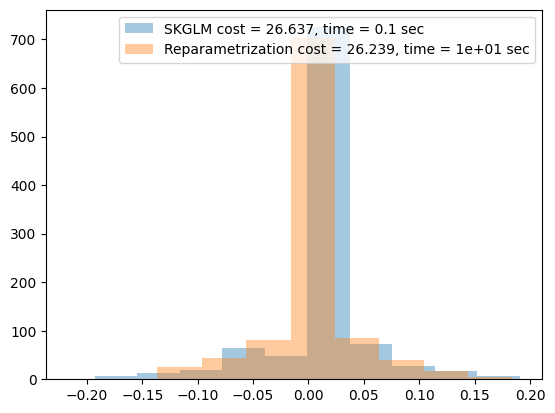

In [247]:
def show_results(lasso_problem: LASSOProblem):
    for algorithm, run in lasso_problem.runs.items():
        plt.hist(
            run.w,
            alpha=0.4,
            label='%s cost = %g, time = %.1g sec' % (
                algorithm, lasso_problem.cost(run.w), run.time_sec
            )
        )

    plt.legend(fontsize=10)
    print("cond(A)=", np.linalg.cond(lasso_problem.A))
    
show_results(lasso_problem)

SKGLM is faster than reparametrization trick in this case. However, I cannot get it to achieve as low of a cost as the reparametrization trick. I've tried reducing  its tolerance parameter, but it gets stuck when i set tol=1e-18, for example. Nevertheless, the histogram above reveals its answer is similar to the reparametrization trick.

# Ill-conditioned problems

Let's see what happens when the LASSO problem is ill-conditioned. This is where second order methods shine.

In [239]:
ill_conditioned_lasso_problem = LASSOProblem.random_ill_conditioned_problem()

In [240]:
LASSO_reparametrized_nonlinear_least_squares(ill_conditioned_lasso_problem, max_nfev=10)

The maximum number of function evaluations is exceeded.
Function evaluations 10, initial cost 8.2512e+03, final cost 8.1551e+03, first-order optimality 8.26e+02.


In [241]:
LASSO_skglm(ill_conditioned_lasso_problem, max_iter=10)

cond(A)= 2980.9579870417915


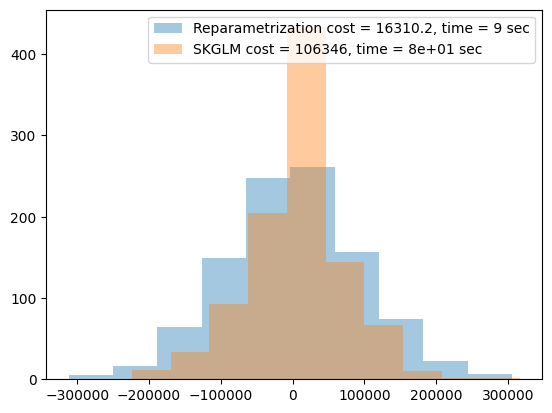

In [242]:
show_results(ill_conditioned_lasso_problem)

On a badly conditioned problem, SKGLM reach similar costs, but SKGLM is 10x slower than the reparametrization trick. This is expected, because the reparametrization trick relies on a quasi-Newton solver, which preconditions the problem with an estimate of the Hessian. Notice also that a small change of ~2% in the cost amounts to a very large change in the solution vector: the histograms of parameter values differ dramatically.